In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt
import textwrap
import os

In [8]:
def berechne_f_y (y0,b,I0,Q,kStr,m):
    A = y0*b + m*y0*y0
    Lu = math.sqrt(1.0+m*m)*2.0*y0 + b
    r_hy = A/Lu
    f_y = (A * kStr * r_hy**(2/3) * I0**0.5) - Q
    return f_y


### Beginn: Zur Berechnung der DGL benötigte Funktionen
def dh_von_dx(dx,I_0,Q,k_str,r_hy,A,b,m,h):
    zaehler = dx * (I_0 - Q*Q/(k_str * k_str * r_hy**(4/3) * A*A))
    nenner = 1. - Q*Q*(b+h*m)/(9.81*A*A*A)
    dh = zaehler/nenner
    return dh

def berechne_querschnitt(h,b,m):
    A = b*h + m*h*h
    L_u = b + 2*h*math.sqrt(1.+m*m)
    r_hy = A/L_u
    return(A,r_hy)
### Ende: Zur Berechnung der DGL benötigte Funktionen

### Beginn: Definition der Klasse Spiegellinie
class Spiegellinie:
    def __init__(self, dx, dx_scale, grenze, h_N, h_gr, h_start, name):
        self.dx = dx
        self.dx_scale = dx_scale
        self.grenze = grenze
        self.h_N = h_N
        self.h_gr = h_gr
        self.h_start = h_start
        self.name = name
    
    def berechnung(self):
        print("Berechnung der Spiegellinie.")
        h_0 = self.h_start
        z_0 = 0.0
        z_So = z_0
        z_Wsp = z_So+h_0
        A,r_hy = berechne_querschnitt(h_0,b,m)
        v = Q/A
        z_H = z_So + h_0 + v*v/19.62
        x = 0
        dx = self.dx
        kurven = np.empty((0,4),dtype=np.float64)
        neue_Zeile = np.array([[x,z_So,z_Wsp,z_H]], dtype=np.float64)
        kurven = np.append(kurven,neue_Zeile,axis=0)
        #print(kurven)
        while (abs(h_0-self.grenze)>0.01):
            x = x+dx
            A,r_hy = berechne_querschnitt(h_0,b,m)
            v = Q/A
            dh = dh_von_dx(dx,I_0,Q,k_str,r_hy,A,b,m,h_0)
            h_0 = h_0 + dh
            z_So = z_0 - x*I_0
            z_Wsp = z_So + h_0
            z_H = z_So + h_0 + v*v/19.62
            neue_Zeile = np.array([[x,z_So,z_Wsp,z_H]], dtype=np.float64)
            kurven = np.append(kurven,neue_Zeile,axis=0)
            #print(kurven)
            dx = dx * self.dx_scale
            # jetzt die Plots
        x_plot = kurven[:,0]
        y_plot_1 = kurven[:,1]
        y_plot_2 = kurven[:,2]
        y_plot_3 = kurven[:,3]
        plt.plot(x_plot,y_plot_1)
        plt.plot(x_plot,y_plot_2)
        plt.plot(x_plot,y_plot_3)
        string_title = self.name + "-Spiegellinie: Sohle, Wasserspiegel, Energielinie"
        plt.title(string_title)
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.show()
### Ende: Definition der Klasse Spiegellinie

Dieses Programm berechnet für vorgegebenen Abfluss Q, Sohlgefälle I_0, Strickler-Wert k_str, Breite b und Böschungsneigung m die zugehörige Normalabflusstiefe, die Grenzabflusstiefe und die Froude-Zahl bei Normalabfluss. Außerdem wird der Gefälletyp (mild oder steil) bestimmt.

Darüberhinaus können Spiegellinien (M1, M2, M3, S1, S2, S3) berechnet und geplottet werden, je nach vorgegebenem Startwert einer Wassertiefe. Zu beachten ist dabei, dass bei strömendem Abfluss die zugrundeliegende Differentialgleichung von unterstrom nach oberstrom gelöst wird. Bei schießendem Abfluss erfolgt dies entsprechend andersherum. Dementsprechend werden die x-Achsen positiv oder negative Werte aufweisen bei den Plots.

#### Beginne nun mit der Eingabe. Achte auf 'sinnvolle' Werte, sonst keine Garantie, dass das Programm durchläuft!

In [9]:
Q= 1000 # Durchfluss Q in m^3/s
b= 2 # Breite b in m
m= 0.001 # Böschungsneigung m [-] 
k_str= 30 # Stricklerbeiwert k_str in m^(1/3) /s
I_0= 0.002 # Sohlgefälle I_0 [-]

#### Berechnung des Normalabflusszustands und Grenzabfluss

In [10]:
y0 = Q/b # Startwertschätzung für Iteration (gibt's bessere Ideen?)
yneu = y0
yalt = y0+1 # um die Schleife sicher zu aktivieren
while abs(yneu-yalt)>0.001:
    f_y = berechne_f_y (yneu,b,I_0,Q,k_str,m)
    # Ableitung numerisch berechnen
    dy = 0.00000001*f_y
    fplus = berechne_f_y (yneu+dy,b,I_0,Q,k_str,m)
    fminus = berechne_f_y (yneu-dy,b,I_0,Q,k_str,m)
    fabl = (fplus-fminus)/(2*dy)
    yalt = yneu
    #print("aktueller Iterationswert:", yneu, "\n")
    yneu = yneu - (1/fabl)*f_y

h_N = yneu
v_N = Q/(yneu*b)
Fr_N = v_N/(9.81*yneu)**0.5
# jetzt h_gr ausrechnen (bissle murksige Methode in zwei Schritten weil Trapez)
q = Q/b
h_gr = (q*q/9.81)**(1/3)
q = Q/(b+m*h_gr)
h_gr = (q*q/9.81)**(1/3)

print("Berechnet wurden: ")
print("Normalabflusstiefe:", round(h_N,2), "m")
print("Geschwindigkeit bei Normalabfluss:", round(v_N,2), "m/s")
print("Froude-Zahl:", round(Fr_N,2))
print("H_0 bei Normalabfluss:", round(yneu+v_N*v_N/19.62,2), "m")
print("Grenzabflusstiefe:", round(h_gr,2), "m")
### Ende: Berechnung des Normalabflusszustands und Grenzabfluss

Berechnet wurden: 
Normalabflusstiefe: 296.63 m
Geschwindigkeit bei Normalabfluss: 1.69 m/s
Froude-Zahl: 0.03
H_0 bei Normalabfluss: 296.77 m
Grenzabflusstiefe: 29.14 m


Das Gefälle ist mild. Es können M1-Kurve, M2-Kurve oder M3-Kurve dargestellt
werden.
Wähle M1 mit der Taste '1' oder entsprechend M2/M3 mit '2' oder '3'. Wähle '4' für Beenden2
M2 benötigt einen Startwert kleiner als Normalabflusstiefe (hier: 296.625 m) und größer als Grenzabflusstiefe (hier: 29.143 m):
Bitte Startwert eingeben: 32
Berechnung der Spiegellinie.


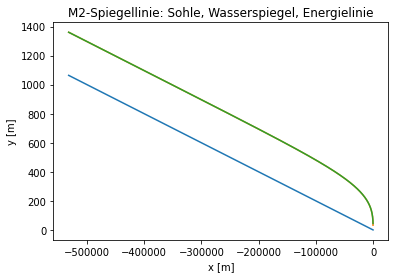

Wähle M1 mit der Taste '1' oder entsprechend M2/M3 mit '2' oder '3'. Wähle '4' für Beenden4
ENDE


In [11]:
### Spiegellinienberechnung
if (Fr_N<1):
    gefaelle_message = "Das Gefälle ist mild. Es können M1-Kurve, M2-Kurve oder M3-Kurve dargestellt werden." 
    print(textwrap.fill(gefaelle_message,80))
    welche_Kurve = input("Wähle M1 mit der Taste '1' oder entsprechend M2/M3 mit '2' oder '3'. Wähle '4' für Beenden")
    welche_Kurve = int(welche_Kurve)
    while ((welche_Kurve == 1) or (welche_Kurve == 2) or (welche_Kurve == 3)):
        if(welche_Kurve == 1):
            print("M1 benötigt einen Startwert größer als Normalabflusstiefe (hier:", round(h_N,3), "m):")
            h_start = input("Bitte Startwert eingeben: ")
            h_start = float(h_start)
            dx = -0.01  
            dx_scale = 1.05
            grenze = h_N
            M1 = Spiegellinie(dx,dx_scale,grenze,h_N,h_gr,h_start,"M1")
            M1.berechnung()
            welche_Kurve = input("Wähle M1 mit der Taste '1' oder entsprechend M2/M3 mit '2' oder '3'. Wähle '4' für Beenden")
            welche_Kurve = int(welche_Kurve)
        elif(welche_Kurve == 2):
            print("M2 benötigt einen Startwert kleiner als Normalabflusstiefe (hier:", round(h_N,3), "m) und größer als Grenzabflusstiefe (hier:", round(h_gr,3), "m):")
            h_start = input("Bitte Startwert eingeben: ")
            h_start = float(h_start)
            dx = -0.01  
            dx_scale = 1.01
            grenze = h_N
            M2 = Spiegellinie(dx,dx_scale,grenze,h_N,h_gr,h_start,"M2")
            M2.berechnung()
            welche_Kurve = input("Wähle M1 mit der Taste '1' oder entsprechend M2/M3 mit '2' oder '3'. Wähle '4' für Beenden")
            welche_Kurve = int(welche_Kurve)
        elif(welche_Kurve == 3):
            print("M3 benötigt einen Startwert kleiner als Grenzabflusstiefe (hier:", round(h_gr,3), "m):")
            h_start = input("Bitte Startwert eingeben: ")
            h_start = float(h_start)
            dx = 0.001  
            dx_scale = 1.0
            grenze = h_gr
            M3 = Spiegellinie(dx,dx_scale,grenze,h_N,h_gr,h_start,"M3")
            M3.berechnung()
            welche_Kurve = input("Wähle M1 mit der Taste '1' oder entsprechend M2/M3 mit '2' oder '3'. Wähle '4' für Beenden")
            welche_Kurve = int(welche_Kurve)
    print("ENDE")

elif (Fr_N>1):
    gefaelle_message = "Das Gefälle ist steil. Es können S1-Kurve, S2-Kurve oder S3-Kurve dargestellt werden."
    print(textwrap.fill(gefaelle_message,80))
    welche_Kurve = input("Wähle S1 mit der Taste '1' oder entsprechend S2/S3 mit '2' oder '3'. Wähle '4' für Beenden")
    welche_Kurve = int(welche_Kurve)
    while ((welche_Kurve == 1) or (welche_Kurve == 2) or (welche_Kurve == 3)):
        if(welche_Kurve == 1):
            print("S1 benötigt einen Startwert größer als Normalabflusstiefe (hier:", round(h_N,3), "m):")
            h_start = input("Bitte Startwert eingeben: ")
            h_start = float(h_start)
            dx = -0.005
            dx_scale = 1.0001
            grenze = h_gr
            S1 = Spiegellinie(dx,dx_scale,grenze,h_N,h_gr,h_start,"S1")
            S1.berechnung()
            welche_Kurve = input("Wähle S1 mit der Taste '1' oder entsprechend S2/S3 mit '2' oder '3'. Wähle '4' für Beenden")
            welche_Kurve = int(welche_Kurve)
        elif(welche_Kurve == 2):
            print("S2 benötigt einen Startwert größer als Normalabflusstiefe (hier:", round(h_N,3), "m) und kleiner als Grenzabflusstiefe (hier:", round(h_gr,3), "m):")
            h_start = input("Bitte Startwert eingeben: ")
            h_start = float(h_start)
            dx = 0.001
            dx_scale = 1.01
            grenze = h_N
            S2 = Spiegellinie(dx,dx_scale,grenze,h_N,h_gr,h_start,"S2")
            S2.berechnung()
            welche_Kurve = input("Wähle S1 mit der Taste '1' oder entsprechend S2/S3 mit '2' oder '3'. Wähle '4' für Beenden")
            welche_Kurve = int(welche_Kurve)
        elif(welche_Kurve == 3):
            print("S3 benötigt einen Startwert kleiner als Normalabflusstiefe (hier:", round(h_N,3), "m):")
            h_start = input("Bitte Startwert eingeben: ")
            h_start = float(h_start)
            dx = 0.05
            dx_scale = 1.001
            grenze = h_N
            S3 = Spiegellinie(dx,dx_scale,grenze,h_N,h_gr,h_start,"S3")
            S3.berechnung()
            welche_Kurve = input("Wähle S1 mit der Taste '1' oder entsprechend S2/S3 mit '2' oder '3'. Wähle '4' für Beenden")
            welche_Kurve = int(welche_Kurve)
    print("ENDE")
